# Crowd Counting - Demo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
import time
from datetime import datetime
import re
from glob import glob
import shutil
import random

from sklearn.model_selection import train_test_split
from PIL import Image
from scipy.ndimage import gaussian_filter
from skimage.io import imread_collection
from scipy.io import loadmat


import torch
from torchinfo import summary
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.transforms import Lambda, Compose, PILToTensor, ToTensor


from IPython.display import clear_output

import cv2     # for capturing videos
import math    # for mathematical operations

''' SEED Everything '''
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True 
seed=42
seed_everything(seed=seed)

print("Using torch", torch.__version__) # colab= 1.10.0+cu111

Using torch 1.12.1+cu102


## 1. Load Data

In [6]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from load_data import load_data


drive          = '/home/muhammada'         
dataset_path   = drive + '/PDRA/works/cc_datasets/Mall'
# data_path = ./dataset/
train_img_paths, train_gt_paths, val_img_paths, val_gt_paths = load_data(dataset_path=dataset_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

>>>>>>>> Dataset is successfuly loaded .. 😀

Train data (img/gt)   :  1400 = 1400
Test data (img/gt)    :  600 = 600
Total data (img/gt)   :  2000 = 2000


## 2. Create Dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
img, gt torch.Size([3, 480, 640]) torch.Size([1, 120, 160])


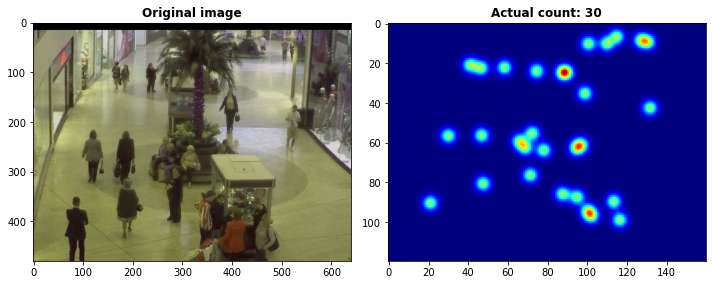

In [20]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from Dataset import CrowdDataset
from utils import display_sample



## For dataset of same size
img_downsample = 1
gt_downsample  = 4 ## This is the model output size as compared to input
sigma    = 10
train_ds  =  CrowdDataset(train_img_paths, train_gt_paths, img_downsample, gt_downsample, sigma=sigma, augmentation=True)  # img_size, gt_size = None for arbitrary shapes
val_ds    =  CrowdDataset(val_img_paths, val_gt_paths, img_downsample, gt_downsample, sigma=sigma, augmentation=False)  # img_size, gt_size = None for arbitrary shapes


###############  Taking a subset for test (Comment the below three lines to use full dataset)
# from torch.utils.data import Subset
# train_ind = torch.randint(low=0, high=200, size=(16,))
# train_ds = Subset(train_ds, train_ind)


#### Dataloaders
train_dl  = torch.utils.data.DataLoader(train_ds, batch_size=32, num_workers=2, pin_memory=True, shuffle=True) # pre_load=True
val_dl    = torch.utils.data.DataLoader(val_ds,  batch_size=1, num_workers=2, pin_memory=True, shuffle=True)



## Run
i = 0
img, gt = train_dl.dataset[i]
fig = display_sample(img, gt)
print('img, gt', img.shape, gt.shape)






## Create Model

In [21]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from utils import save_checkpoint, load_checkpoint

from models.MCNN import MCNN
from models.CSRNet import CSRNet


torch.backends.cudnn.enabled   = True
torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()


# Define Model
model_name =  'MCNN'
models = {'MCNN':MCNN(), 'CSRNet':CSRNet()}
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # torch.device("cuda")  ## 'cuda', 'cpu'
criterion    = nn.MSELoss(reduction='sum')#.to(device)  # MSELoss, L1Loss  ## reduction=sum, mean, none
model        = models[model_name].to(device)
# model        = nn.DataParallel(model) # multiple GPU
optim        = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False) # weight_decay=1e-3
lr_scheduler = None
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=0.1, patience=5, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
n_epochs     = 10  ### you can choose large number to converge
val_metric   = np.Inf
checkpoint   = f'{os.getcwd()}/checkpoints/{model_name}.pt' 
params       = {'model': model, 'train_dl':train_dl, 'val_dl': val_dl,'n_epochs': n_epochs, 'device': device, 'optimizer': optim, 
                      'criterion':criterion,'lr_scheduler':lr_scheduler, 'val_metric': val_metric, 'checkpoint': checkpoint}
print(f'Model will be saved to >>>> {checkpoint}')

## Visualize the model
img, gt    =  train_ds[0] # (1,3,512,640)
input_size = (1,3,480,640) # img.unsqueeze(0).shape  # (1,3,256,256) # 
print('Model Output', model(torch.rand(input_size).to(device)).shape)
summary(model, input_size=input_size, col_width=20, col_names=["kernel_size", "output_size", "num_params", "mult_adds"]) # https://pypi.org/project/torchinfo/
# print(model)





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Model will be saved to >>>> /home/muhammada/PDRA/works/Demos/cc-demo/checkpoints/MCNN.pt
Model Output torch.Size([1, 1, 120, 160])


Layer (type:depth-idx)                   Kernel Shape         Output Shape         Param #              Mult-Adds
MCNN                                     --                   --                   --                   --
├─Sequential: 1-1                        --                   [1, 8, 120, 160]     --                   --
│    └─Conv2d: 2-1                       [9, 9]               [1, 16, 480, 640]    3,904                1,199,308,800
│    └─ReLU: 2-2                         --                   [1, 16, 480, 640]    --                   --
│    └─MaxPool2d: 2-3                    2                    [1, 16, 240, 320]    --                   --
│    └─Conv2d: 2-4                       [7, 7]               [1, 32, 240, 320]    25,120               1,929,216,000
│    └─ReLU: 2-5                         --                   [1, 32, 240, 320]    --                   --
│    └─MaxPool2d: 2-6                    2                    [1, 32, 120, 160]    --                   --
│    └─C

## Training

In [22]:
from trainer import trainer
history = trainer(params) ## 156R.xml

You are using GPU:  Quadro RTX 8000
>>>>>>>>>>>>>>>>>>>>>>>>>>>>  updated
Epoch 1 of 10
Epoch:1  ==>         Train/Valid Loss: 0.5431 / 0.5426 ... MAE=5.41
Validation MAE decreased (inf --> 5.41):  Saving model ...
Epoch 2 of 10
Epoch:2  ==>         Train/Valid Loss: 0.5387 / 0.5344 ... MAE=5.25
Validation MAE decreased (5.41 --> 5.25):  Saving model ...
Epoch 3 of 10
Epoch:3  ==>         Train/Valid Loss: 0.5271 / 0.5155 ... MAE=11.75
Epoch 4 of 10
Epoch:4  ==>         Train/Valid Loss: 0.4983 / 0.4799 ... MAE=4.49
Validation MAE decreased (5.25 --> 4.49):  Saving model ...
Epoch 5 of 10
Epoch:5  ==>         Train/Valid Loss: 0.4659 / 0.4510 ... MAE=6.87
Epoch 6 of 10
Epoch:6  ==>         Train/Valid Loss: 0.4450 / 0.4362 ... MAE=11.65
Epoch 7 of 10
Epoch:7  ==>         Train/Valid Loss: 0.4305 / 0.4170 ... MAE=4.47
Validation MAE decreased (4.49 --> 4.47):  Saving model ...
Epoch 8 of 10
Epoch:8  ==>         Train/Valid Loss: 0.4157 / 0.4289 ... MAE=14.29
Epoch 9 of 10
Epoch:9  ==>  

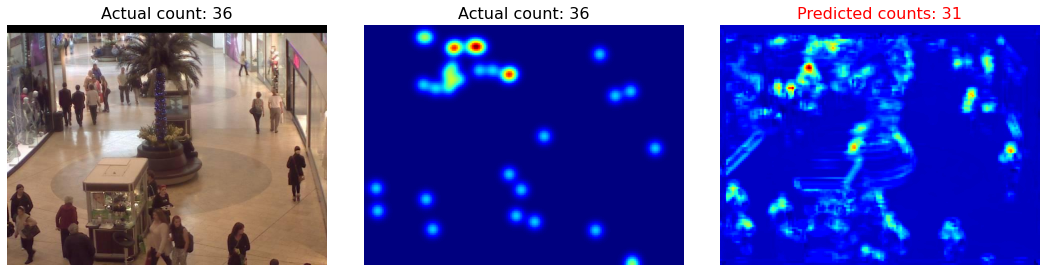

In [32]:
## Predict
from utils import display_prediction

i = 1 # Good: 6, 70  Bad:  3, 10, 17, 6, 134
img, gt = val_dl.dataset[i]
et     = model(img.unsqueeze(0).to(device))
fig = display_prediction(img, gt, et)

## Save Models

In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from cc_trainer import trainer
from cc_utils import load_checkpoint

## load best models
# load_path    = f'{os.getcwd()}/checkpoints/Mall_{model_name}.pt'  ##  backup
# optim         = torch.optim.Adam(model.parameters(), lr=0.000001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-3, amsgrad=True) # 0.00001
# model         = nn.DataParallel(model)
# model, optim, epoch, metric = load_checkpoint(model, optim, device, load_path)
# model.eval()  # For inference only
# print('Model loaded .. ')



## Load weights
# PATH     =  f'{os.getcwd()}/weight/{ds_name}_{model_name}.pt'  ##  backup
# model    = model().to(device)
# model    = nn.DataParallel(model)
# model.module.load_state_dict(torch.load(PATH))
# model.eval()  # For inference only
# print('\nMCNN loaded successfully.. \n')


### Further training
# params['val_metric'] = metric
# params['n_epochs']   = 500
# # checkpoint   = f'{os.getcwd()}/checkpoints/{ds_name}_{model_name}.pt' ## Save checkpoint
# history = trainer(params)


## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Save weights (state_dict)

In [36]:
## Save weights only

# Save whole model
# PATH = f'{os.getcwd()}/pretrained/{ds_name}_{model_name}.pth'  ##  backup
PATH = f'{os.getcwd()}/pretrained/Mall_{model_name}.pth' 
torch.save(model, PATH)

# Save weights only
PATH = f'{os.getcwd()}/weights/Mall_{model_name}.pth'  ##  backup
if isinstance(model, nn.DataParallel):
    print('Multi-GPU ==> Single-GPU before saving .. ')
    torch.save(model.module.state_dict(), PATH)
else:
    torch.save(model.state_dict(), PATH)
print('Model and weights saved ... ')

Model and weights saved ... 


## 5. Predictions

In [39]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from predict import predict


print('Predictions on test_data..')
test_images, test_gt, test_et, test_mae  = predict(model, val_dl, device=device)
# print('Test MAE', test_mae)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Predictions on test_data..


/home/muhammada/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `SSIM` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


MSE: 22.663434982299805
MAE: 3.8425827026367188
GAME 16: 32.65280532836914
SSIM: 0.4733225107192993
PSNR: 21.832128524780273


## 6. Plot counting errors

In [43]:
## Test predictions
test_actual_count  = []
test_pred_count    = []
for i in range(0, len(test_gt)): # test_ds_unbatch.as_numpy_iterator():
    # print(f'Test:  Actual {test_dm[i,:].sum() :.0f} => Predicted {test_dm_h[i,:].sum() :.0f} ')
    test_actual_count.append(torch.sum(test_gt[i,:]))
    test_pred_count.append(torch.sum(test_et[i,:]))
test_actual_count  = torch.tensor(test_actual_count) #.detach().cpu()
test_pred_count    = torch.tensor(test_pred_count) #.detach().cpu()
test_mae2 = abs(test_actual_count - test_pred_count).sum()/len(val_dl.dataset)
print(f'Test MAE : {test_mae2}')

Test MAE : 3.8425827026367188


Images with (Counting Error < 1) = , 88 which is 14.67 %


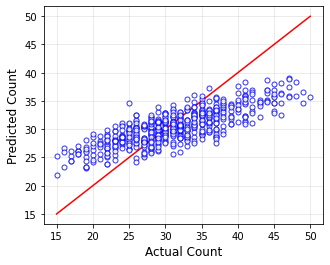

In [45]:
### Test dataset
fig2, ax2 = plt.subplots(1, 1, figsize=(5,4))
p1 = max(max(test_actual_count), max(test_actual_count)).cpu()
p2 = min(min(test_pred_count), min(test_actual_count)).cpu()
ax2.plot([p1,p2], [p1,p2], 'r-')
ax2.plot(test_actual_count, test_pred_count, ls='', marker='o', markersize=5, markerfacecolor='w', markeredgecolor='blue', markeredgewidth=1, alpha=0.8)
plt.grid(alpha=0.3)
ax2.set_xlabel('Actual Count', fontsize=12, fontweight='medium')
ax2.set_ylabel('Predicted Count', fontsize=12, fontweight='medium')
# ax2.set_title(f'MAE (Test set) = {test_mae2 :.1f}', fontsize=12, fontweight='bold')
plt.savefig(f'SelfMCNN_errors.pdf', dpi=300, transparent=True)


## See some stats
threshold = 1
abs_error = abs(test_actual_count - test_pred_count)
count         = (abs_error<threshold).sum().numpy()
count_percent = (count/len(val_ds)) * 100
print(f'Images with (Counting Error < {threshold}) = , {count} which is {count_percent :.2f} %' )



Note:-

We used MCNN model which is a shallow model and is not very accurate. Other models can be trained in the same way e.g., CSRNet to get more accurate crowd counting performance.